# Prophet Modelling

Installing library

In [ ]:
pip install prophet

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ------- -------------------------------- 2.4/13.3 MB 11.2 MB/s eta 0:00:01
   -------------- ------------------------- 5.0/13.3 MB 11.6 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/13.3 MB 11.9 MB/s eta 0:00:01
   ----------------------------- ---------- 9.7/13.3 MB 11.8 MB/s eta 0:00:01
   ------------------------------------ --- 12.3/13.3 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 11.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/991.0 kB ? eta -:--:--
   --------------------------------------- 991.0/991.0 kB 11.6 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [importlib_resources]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------------- 2/5 [holidays]
   ---------------- ----------------------- 2/5

Baseline Model

15:05:09 - cmdstanpy - INFO - Chain [1] start processing
15:08:07 - cmdstanpy - INFO - Chain [1] done processing


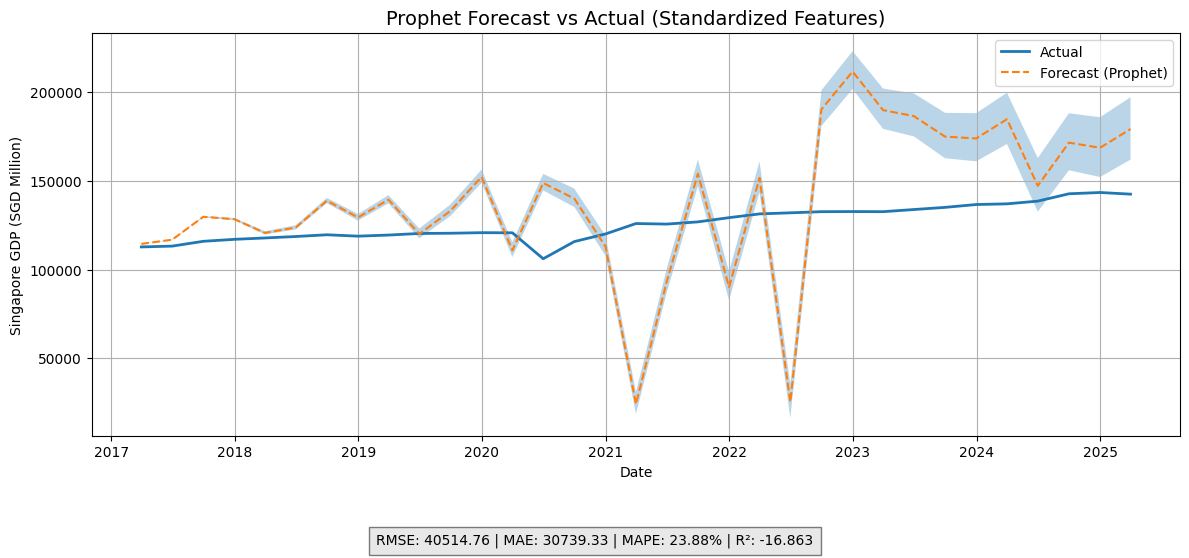

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("RegressionFeatures.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)

# Separate target and features
y = df['sg_gdp']
X = df.drop(columns=['sg_gdp'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Prepare Prophet dataframe

prophet_df = X_scaled_df.copy()  # use scaled features
prophet_df['ds'] = df.index
prophet_df['y'] = y

# Train-test split
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Identify feature columns
all_features = [col for col in prophet_df.columns if col not in ['ds', 'y']]

# Model training with Prophet
model = Prophet()
for feature in all_features:
    model.add_regressor(feature)

model.fit(train_df)

# Forecast on test set
future = test_df[['ds'] + all_features]
forecast = model.predict(future)

# Evaluate the forecast
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

# Plotting the results
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', linewidth=2)
plt.plot(forecast['ds'], y_pred, label='Forecast (Prophet)', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.title('Prophet Forecast vs Actual (Standardized Features)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Singapore GDP (SGD Million)')
plt.legend()
plt.grid(True)

# Display metrics
metrics_text = f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}"
plt.figtext(0.5, -0.1, metrics_text, ha='center', fontsize=10,
            bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5})

plt.tight_layout()
plt.show()

Feature Selection

In [56]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# Load your engineered dataset
df = pd.read_csv("RegressionFeatures.csv", index_col=0, parse_dates=True)
df.index = pd.to_datetime(df.index)
df.dropna(inplace=True)

# Define target and features
y = df['sg_gdp']
X = df.drop(columns=['sg_gdp'])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LassoCV
lasso = LassoCV(cv= 10, max_iter=10000, random_state=1)
lasso.fit(X_scaled, y)

# Get selected features
selected_features = X.columns[lasso.coef_ != 0]
print(f"\n==> Selected {len(selected_features)} features:\n", selected_features.tolist())

# Filter dataframe to only selected features
X_selected = X[selected_features]


==> Selected 16 features:
 ['hk_gdp_growth', 'us_gdp_growth', 'rsi', 'us_gdp_growth_lag3', 'sti_close_lag4', 'sg_gdp_lag4', 'sti_close_qoq_pct', 'sg_gdp_qoq_pct', 'us_gdp_growth_rollmean2', 'sg_cpi_rollmean2', 'iip_rollstd2', 'iip_rollmean4', 'iip_rollstd4', 'rsi_rollstd2', 'total_tourists_rollstd2', 'sg_gdp_rollmean2']


Model Definition & Fitting

In [ ]:
from prophet import Prophet

prophet_df = df[['sg_gdp']].copy()
prophet_df['ds'] = df.index
prophet_df['y'] = prophet_df['sg_gdp']
prophet_df.drop(columns=['sg_gdp'], inplace=True)

# Add selected regressors
for feature in selected_features:
    prophet_df[feature] = X_selected[feature].values

# Train/test split
train_size = int(len(prophet_df) * 0.7)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Initialize Prophet model
model = Prophet()

# Add regressors/exog features
for feature in selected_features:
    model.add_regressor(feature)
    print(f"Added regressor: {feature}")

model.fit(train_df)

15:12:50 - cmdstanpy - INFO - Chain [1] start processing


Train shape: (76, 18)
Test shape: (33, 18)
Added regressor: hk_gdp_growth
Added regressor: us_gdp_growth
Added regressor: rsi
Added regressor: us_gdp_growth_lag3
Added regressor: sti_close_lag4
Added regressor: sg_gdp_lag4
Added regressor: sti_close_qoq_pct
Added regressor: sg_gdp_qoq_pct
Added regressor: us_gdp_growth_rollmean2
Added regressor: sg_cpi_rollmean2
Added regressor: iip_rollstd2
Added regressor: iip_rollmean4
Added regressor: iip_rollstd4
Added regressor: rsi_rollstd2
Added regressor: total_tourists_rollstd2
Added regressor: sg_gdp_rollmean2


15:12:51 - cmdstanpy - INFO - Chain [1] done processing


Forecasting Visualization


     EVALUATION     
RMSE: 1897.926 | MAE: 1635.115 | MAPE: 1.30% | R²: 0.961 | Adjusted R²: 0.922 | Theil's U: 0.536


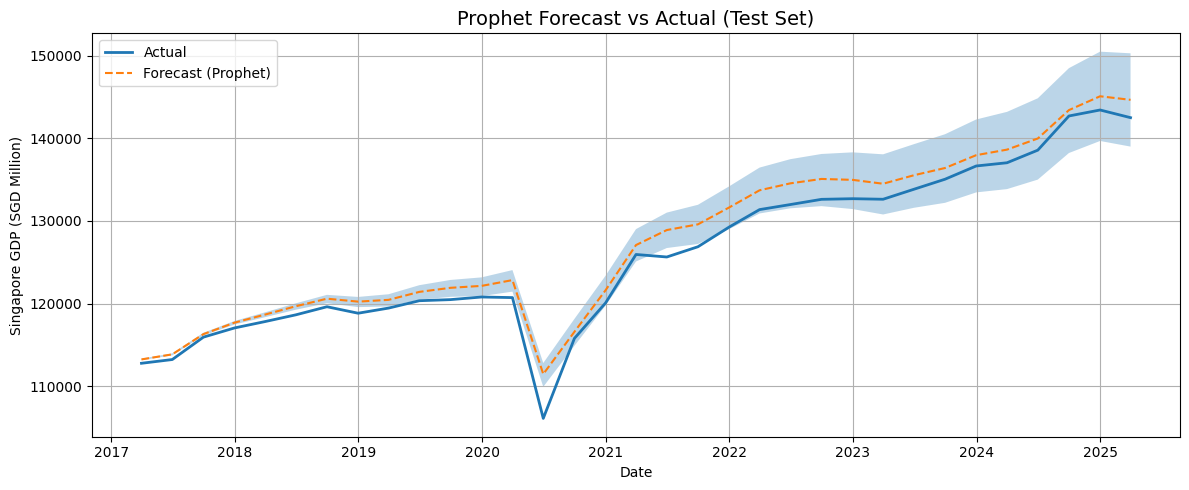

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prediction
future = test_df[['ds'] + selected_features.tolist()]
forecast = model.predict(future)

# Evaluation Metrics
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)
# Adjusted R-squared
n = len(y_true)
k = len(selected_features)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Convert y_true and y_pred to Series for indexing
y_true_series = pd.Series(y_true, index=test_df['ds'])
y_pred_series = pd.Series(y_pred, index=test_df['ds'])

# Generate naive forecast (previous actual value)
naive_forecast = y_true_series.shift(1).dropna()

# Align actual and predicted to naive (remove first value)
y_true_aligned = y_true_series.iloc[1:]
y_pred_aligned = y_pred_series.iloc[1:]

# Compute RMSEs
rmse_model = np.sqrt(mean_squared_error(y_true_aligned, y_pred_aligned))
rmse_naive = np.sqrt(mean_squared_error(y_true_aligned, naive_forecast))

# Theil’s U-statistic (U2)
theils_u = rmse_model / rmse_naive


print("\n====================")
print("     EVALUATION     ")
print("====================")
print(f"RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f} | Adjusted R²: {adj_r2:.3f} | Theil's U: {theils_u:.3f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', linewidth=2)
plt.plot(forecast['ds'], y_pred, label='Forecast (Prophet)', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.title('Prophet Forecast vs Actual (Test Set)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Singapore GDP (SGD Million)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
import joblib

joblib.dump(model, 'sg_gdp_prophet.pkl')

['sg_gdp_prophet.pkl']

### Creating future exog variables through regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

file_path = r"D:\PyTorch Projects\Malaysia_GDP\Code\RegressionFeatures.csv"  
df = pd.read_csv(file_path, parse_dates=["date"])
last_date = df["date"].max()
future_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), end="2030-12-31", freq="Q")

regressors = [
    'hk_gdp_growth',
    'us_gdp_growth',
    'rsi',
    'us_gdp_growth_lag3',
    'sti_close_lag4',
    'sg_gdp_lag4',
    'sti_close_qoq_pct',
    'sg_gdp_qoq_pct',
    'us_gdp_growth_rollmean2',
    'sg_cpi_rollmean2',
    'iip_rollstd2',
    'iip_rollmean4',
    'iip_rollstd4',
    'rsi_rollstd2',
    'total_tourists_rollstd2',
    'sg_gdp_rollmean2'
]

df = df.copy()
df["t"] = np.arange(len(df))

# Create future time index 
future_df = pd.DataFrame({"ds": future_dates})
future_df["t"] = np.arange(len(df), len(df) + len(future_df))

for col in regressors:
    temp_df = df[["t", col]].dropna()
    
    if temp_df.empty or temp_df[col].nunique() <= 1:
        print(f"[{col}] - Not enough variability, using constant extrapolation.")
        future_df[col] = df[col].iloc[-1]
    else:
        model = LinearRegression()
        model.fit(temp_df[["t"]], temp_df[col])
        future_df[col] = model.predict(future_df[["t"]])
        print(f"[{col}] - Extrapolated using linear regression.")

future_df.drop(columns="t", inplace=True)
future_df.to_csv("FutureValues", index=False)

[hk_gdp_growth] - Extrapolated using linear regression.
[us_gdp_growth] - Extrapolated using linear regression.
[rsi] - Extrapolated using linear regression.
[us_gdp_growth_lag3] - Extrapolated using linear regression.
[sti_close_lag4] - Extrapolated using linear regression.
[sg_gdp_lag4] - Extrapolated using linear regression.
[sti_close_qoq_pct] - Extrapolated using linear regression.
[sg_gdp_qoq_pct] - Extrapolated using linear regression.
[us_gdp_growth_rollmean2] - Extrapolated using linear regression.
[sg_cpi_rollmean2] - Extrapolated using linear regression.
[iip_rollstd2] - Extrapolated using linear regression.
[iip_rollmean4] - Extrapolated using linear regression.
[iip_rollstd4] - Extrapolated using linear regression.
[rsi_rollstd2] - Extrapolated using linear regression.
[total_tourists_rollstd2] - Extrapolated using linear regression.
[sg_gdp_rollmean2] - Extrapolated using linear regression.


C:\Users\Travi\AppData\Local\Temp\ipykernel_101872\2578645353.py:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=last_date + pd.offsets.QuarterEnd(), end="2030-12-31", freq="Q")


In [3]:
import requests

url = "https://sg-gdp-api-251882328088.asia-southeast1.run.app/predict?year=2026"
#params = {"year": 2026}

response = requests.get(url)
response.json()


{'year': 2026,
 'model': 'Prophet GDP Forecaster',
 'GDP Value': [{'quarter': 'Q1',
   'gdp_prediction': 147463.27,
   'upper_boundary': 147568.27,
   'lower_boundary': 147354.0},
  {'quarter': 'Q2',
   'gdp_prediction': 148464.06,
   'upper_boundary': 148591.15,
   'lower_boundary': 148351.52},
  {'quarter': 'Q3',
   'gdp_prediction': 149387.47,
   'upper_boundary': 149560.41,
   'lower_boundary': 149239.72},
  {'quarter': 'Q4',
   'gdp_prediction': 150410.77,
   'upper_boundary': 150651.89,
   'lower_boundary': 150203.47}]}

In [ ]:
import requests

url = "https://sg-gdp-api-431845328088.asia-southeast1.run.app/predict?year=2026"
params = {"year": 2026}

response = requests.get(url, params=params)
print(response.json())